# Given the stock information of at least the past 5 days of one particular company, try to predict the closing price of that company on a particular day

# Load libraries

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load training set and process date to ensure it is parseable

In [213]:
# Load the dataset
train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", train_data.columns)
print(train_data.head())

# Convert 'Date' to datetime, handling errors
train_data['Date'] = pd.to_datetime(train_data['Date'], errors='coerce')

# Check for NaT values after conversion
if train_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(train_data[train_data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2020-09-30  100.940002  1362200      A                       14.0   
1  2020-10-01  101.220001   723600      A                        0.0   
2  2020-10-02  100.010002   712200      A                        0.0   
3  2020-10-05  103.120003   803900      A                 

C:\Users\Admin\AppData\Local\Temp\ipykernel_12820\2972640794.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Define your company of interest and obtain its closing price for the days in training set (n>= 5)

In [214]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
company = 'AMT' 

# Filter data for the specific company
company_data = train_data[train_data['Symbol'] == company]

# Check if company is in dataset
if company_data.empty:
    raise ValueError(f"No data found for company: {company}")

# Set the 'Date' column as the index
company_data.set_index('Date', inplace=True)

# Ensure we have at least 5 days of data
if len(company_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# train n days for modeling - we will use entire length of training set
train_n_days = company_data['Close']

# Ensure 'train_n_days' is not empty
if train_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

# Perform Rolling-window Cross Validation

In [215]:
# Define rolling window parameters
n = len(train_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1


# library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are additive or multiplicative

In [216]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = train_n_days.iloc[:train_size + start]
    test = train_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast) 
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  2.574682
1   add      mul  2.574986
2   mul      add  2.575766
3   mul      mul  2.576132
Lowest RMSE: 2.5746819389774354
Trend: add, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: Runtim

# Input the trend and seasonality, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [217]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    train_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7
).fit()

print(model.summary())

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                           3153.795
Optimized:                         True   AIC                            750.295
Trend:                         Additive   BIC                            791.643
Seasonal:                      Additive   AICC                           751.496
Seasonal Periods:                     7   Date:                 Sat, 02 Nov 2024
Box-Cox:                          False   Time:                         11:29:45
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

# Visualise Holt-Winter's smoothed values and actual values and calculate in-sample RMSE and MAPE

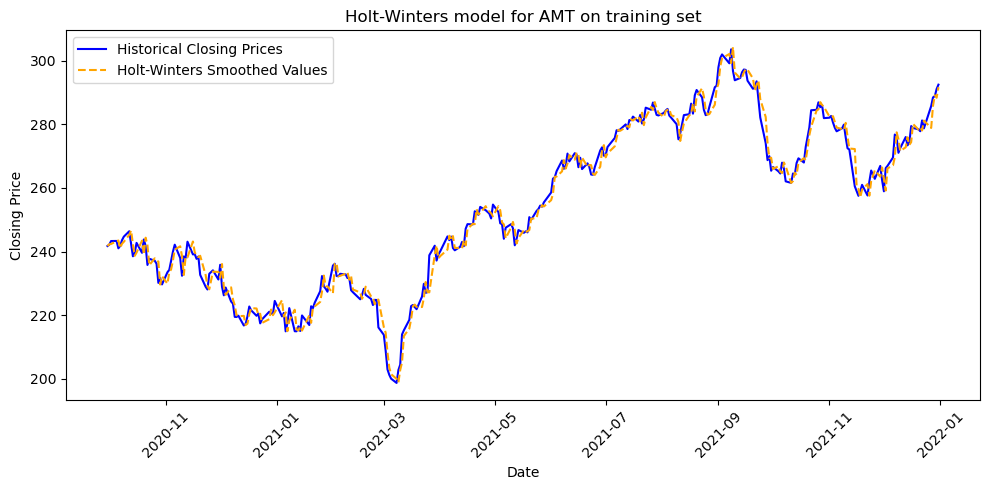

Predicted Closing Price for AMT on the next day: 291.80911398207166
RMSE between smoothed values and historical closing prices: 2.5746819389774354
MAPE between smoothed values and historical closing prices: 0.98%


In [218]:
# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not train entire training set
historical_m_data = company_data['Close'][:]  
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model for {company} on training set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and this model's RMSE and MAPE
print(f'Predicted Closing Price for {company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between smoothed values and historical closing prices: {lowest_rmse_row['rmse']}")
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((train_n_days.values - smoothed_values.values) / train_n_days.values)) * 100
print(f'MAPE between smoothed values and historical closing prices: {mape:.2f}%')


# Forecast using model above and compare against data in TEST set

In [219]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", test_data.columns)
print(test_data.head())

# Convert 'Date' to datetime, handling errors
test_data['Date'] = pd.to_datetime(test_data['Date'], errors='coerce')

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2022-01-03  156.479996  1606300      A                        0.0   
1  2022-01-04  151.190002  2234000      A                        0.0   
2  2022-01-05  148.600006  2370500      A                        0.0   
3  2022-01-06  149.119995  2298300      A                 

# Make forecast, plot against actual values and calculate the out-of-sample RMSE and MAPE

Date
2022-01-03    292.731778
2022-01-04    292.668222
2022-01-05    292.812445
2022-01-06    292.875111
2022-01-07    293.561778
                 ...    
2022-06-24    311.700223
2022-06-27    311.636667
2022-06-28    311.780890
2022-06-29    311.843556
2022-06-30    312.530223
Length: 124, dtype: float64


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


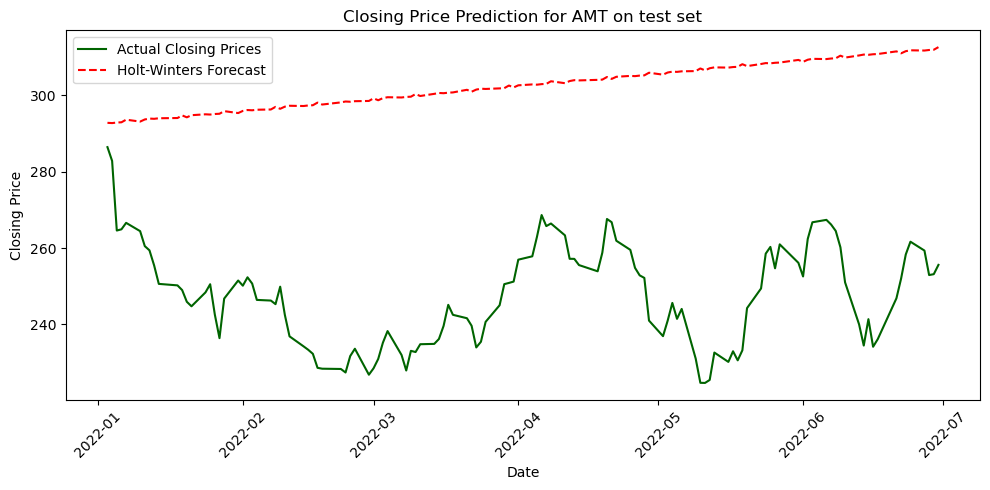

Predicted Closing Price for AMT on the next day: 292.73177775690067
RMSE between forecast values and actual closing prices: 56.659776795009044
MAPE between forecast values and actual closing prices: 18.13%


In [220]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_company ='AMT'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Forecast target company's closing price for the length of test set
forecast = model.forecast(steps=len(test_company_data))

# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not choose entire test set
test_historical_m_data = test_company_data['Close']

# Align predicted values with the test data index
forecast.index = test_historical_m_data.index

# Print the predicted values
print(forecast)

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(forecast.values, test_historical_m_data.values)

# Calculate MAPE
test_mape = np.mean(np.abs((np.array(forecast.values) - np.array(test_historical_m_data.values)) / np.array(forecast.values))) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.2f}%')

# Combine both plots to visualise how the model fitted the training data and forecasted against the test data

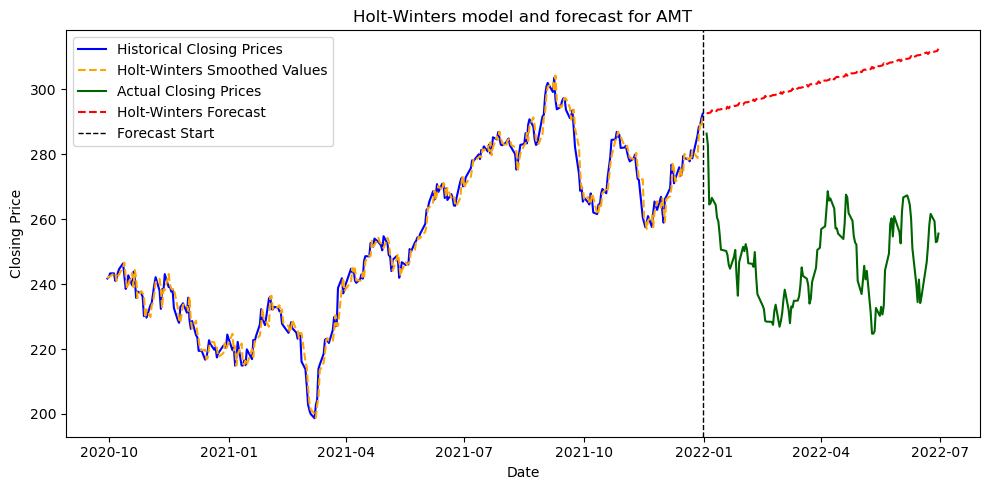

In [221]:
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

In [222]:
hw_mape_dict = {'MMM':16.28, 'XOM':25.77, 'SHW':30.29, 'AMZN':16.57, 'PG':9.48, 'JNJ':2.15, 'JPM':20.02, 'AAPL':15.41, 'GOOGL':18.82, 'NEE':20.24, 'AMT':18.13}

hw_mape_mean = sum(hw_mape_dict.values()) / len(hw_mape_dict.values())  
print("Mean of MAPE values:", hw_mape_mean)

Mean of MAPE values: 17.56


# Rolling Forecast Origin

# a more accurate, adaptive and responsive forecasting method compared to traditional one-time forecasting technique above

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

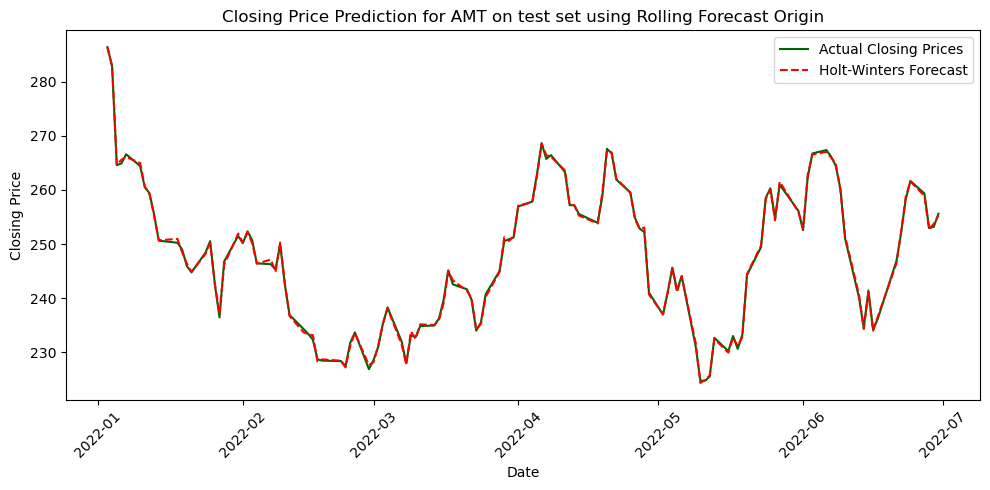

Predicted Closing Price for AMT on the next day: 286.31644472766493
RMSE between forecast values and actual closing prices: 0.38065091598955164
MAPE between forecast values and actual closing prices: 0.13%


In [223]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest 
test_company = 'AMT'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Pre-existing training data from above
train_n_days = company_data['Close']

# Prepare to store forecasts and actual values
forecasts = []
actual_values = []

# Start rolling forecast from the first day of the test set
for i in range(len(test_company_data)):
    # Combine the training data with the current test data point
    combined_data = pd.concat([train_n_days, test_company_data['Close'][:i + 1]])
    
    # Fit the Holt-Winters model
    model = ExponentialSmoothing(combined_data, trend=lowest_trend, seasonal=lowest_seasonal, seasonal_periods=7)
    model_fit = model.fit(optimized=True)
    
    # Forecast the next value
    forecast = model_fit.forecast(steps=1)
    forecasts.append(forecast.values[0])
    actual_values.append(test_company_data['Close'].iloc[i])

# Align predicted values with the test data index for visualisation
forecast_index = test_company_data.index
forecast_series = pd.Series(forecasts, index=forecast_index)

# Calculate RMSE and MAPE
test_rmse = root_mean_squared_error(actual_values, forecasts)
test_mape = np.mean(np.abs((np.array(actual_values) - np.array(forecasts)) / np.array(actual_values))) * 100

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast_series.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.2f}%')


# Combine the two plots again to see the complete graph of how the model fits the training data and forecasts against test data, using Rolling Forecast Origin this time round

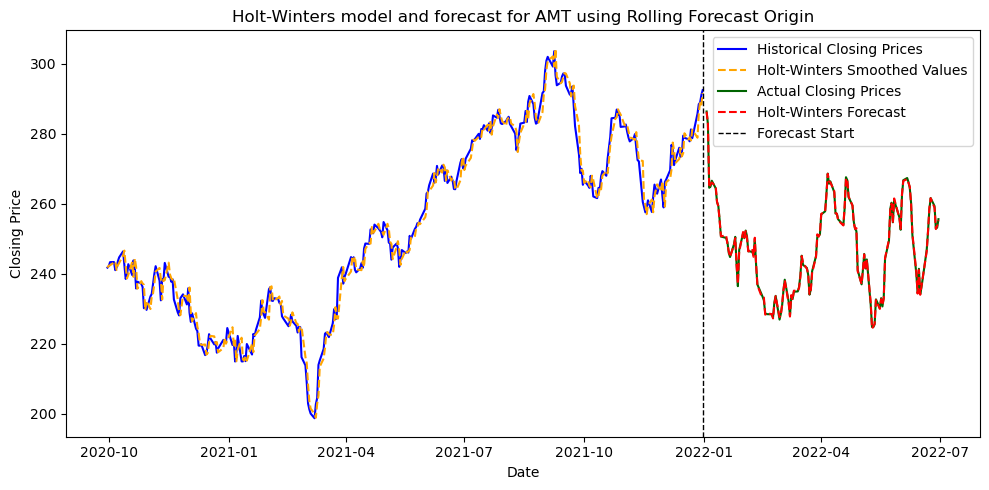

In [224]:
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {company} using Rolling Forecast Origin')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(test_company_data.index, test_company_data['Close'], label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast_series.index, forecast_series, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

In [226]:
hw_mape_rfo_dict = {'MMM':0.25, 'XOM':0.18, 'SHW':0.16, 'AMZN':0.31, 'PG':0.18, 'JNJ':0.10, 'JPM':0.26, 'AAPL':0.16, 'GOOGL':0.15, 'NEE':0.13, 'AMT':0.13}

hw_mape_rfo_mean = sum(hw_mape_rfo_dict.values()) / len(hw_mape_rfo_dict.values())  
print("Mean of MAPE values:", hw_mape_rfo_mean)

Mean of MAPE values: 0.1827272727272727
